# Phase 9.5: Context & Calibration

**Goal:** Add *Strength of Schedule* (rolling opponent Elo) as a new feature, retrain
the ensemble, verify calibration, and re-simulate.

| Step | Purpose |
|------|---------|
| SOS Feature | "Were your wins against good teams or bad teams?" |
| Calibration Curve | "When the model says 70%, do teams actually win 70%?" |
| Re-Simulation | 10k Monte Carlo with context-aware probabilities |

In [1]:
# Ensure working directory is the project root perfectly across IDEs/Terminals
import os
import sys
try:
    if 'notebooks' in os.getcwd():
        project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    else:
        project_root = os.getcwd()
    os.chdir(project_root)
    if project_root not in sys.path:
        sys.path.append(project_root)
except Exception:
    pass

# =============================================================================
# Cell 1: Setup & Data Load
# =============================================================================

import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss

warnings.filterwarnings('ignore')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Segoe UI', 'Arial', 'DejaVu Sans']

proc   = os.path.join('data', 'processed')
res    = os.path.join('data', 'results')
assets = 'Report_Assets'
os.makedirs(res, exist_ok=True)
os.makedirs(assets, exist_ok=True)

simulations = 10_000
seed = 42
np.random.seed(seed)

# --- Load all three sets ---
df_train  = pd.read_csv(os.path.join(proc, 'model_training_engineered.csv'))
df_banked = pd.read_csv(os.path.join(proc, 'current_banked_engineered.csv'))
df_future = pd.read_csv(os.path.join(proc, 'future_predict_engineered.csv'))

# Tag for re-splitting
df_train['_set']  = 'train'
df_banked['_set'] = 'banked'
df_future['_set'] = 'future'

# Combine into one timeline so rolling calcs are continuous
full = pd.concat([df_train, df_banked, df_future], axis=0, ignore_index=True)
full['date'] = pd.to_datetime(full['date'])
full = full.sort_values('date').reset_index(drop=True)

print(f'Train:  {len(df_train):,}')
print(f'Banked: {len(df_banked):,}')
print(f'Future: {len(df_future):,}')
print(f'Combined: {len(full):,}')

Train:  19,837
Banked: 1,104
Future: 648
Combined: 21,589


In [2]:
# =============================================================================
# Cell 2: Feature Engineering — Strength of Schedule (Opponent Elo L5)
# =============================================================================

# Build a long-format table: (date, team, opponent_elo)
home_view = full[['date', 'home_team', 'away_elo']].rename(
    columns={'home_team': 'team', 'away_elo': 'opponent_elo'}
)
away_view = full[['date', 'away_team', 'home_elo']].rename(
    columns={'away_team': 'team', 'home_elo': 'opponent_elo'}
)

team_timeline = pd.concat([home_view, away_view]).sort_values(['team', 'date']).reset_index(drop=True)

# Rolling mean of opponent Elo over last 5 games (shift to avoid leakage)
team_timeline['opp_strength_l5'] = (
    team_timeline.groupby('team')['opponent_elo']
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
)

# De-duplicate: if team has two entries on the same date (e.g. double-header),
# keep only the latest rolling value.
team_sos = team_timeline.drop_duplicates(subset=['date', 'team'], keep='last')

# Merge back: home side
full = full.merge(
    team_sos[['date', 'team', 'opp_strength_l5']],
    left_on=['date', 'home_team'], right_on=['date', 'team'],
    how='left'
).rename(columns={'opp_strength_l5': 'home_opp_strength_l5'}).drop(columns=['team'])

# Merge back: away side
full = full.merge(
    team_sos[['date', 'team', 'opp_strength_l5']],
    left_on=['date', 'away_team'], right_on=['date', 'team'],
    how='left'
).rename(columns={'opp_strength_l5': 'away_opp_strength_l5'}).drop(columns=['team'])

print('New SOS features added!')
print(full[['date', 'home_team', 'home_opp_strength_l5',
            'away_team', 'away_opp_strength_l5']].dropna().tail(5))
print(f'\nhome_opp_strength_l5 NaN: {full["home_opp_strength_l5"].isna().sum()}')
print(f'away_opp_strength_l5 NaN: {full["away_opp_strength_l5"].isna().sum()}')

# --- Re-split ---
train_eng  = full[full['_set'] == 'train'].copy()
banked_eng = full[full['_set'] == 'banked'].copy()
future_eng = full[full['_set'] == 'future'].copy()

print(f'\nRe-split: train={len(train_eng)}, banked={len(banked_eng)}, future={len(future_eng)}')

New SOS features added!
            date   home_team  home_opp_strength_l5   away_team  \
21584 2026-12-04       Celta           1722.603247      Oviedo   
21585 2026-12-04   Barcelona           1716.223169     Espanol   
21586 2026-12-04  Ath Bilbao           1758.763330  Villarreal   
21587 2026-12-04     Levante           1666.534766      Getafe   
21588 2026-12-04      Torino           1758.685815      Verona   

       away_opp_strength_l5  
21584           1611.452710  
21585           1634.364575  
21586           1646.809570  
21587           1632.124121  
21588           1744.225708  

home_opp_strength_l5 NaN: 75
away_opp_strength_l5 NaN: 89

Re-split: train=19837, banked=1104, future=648


In [3]:
# =============================================================================
# Cell 3: Train Context-Aware Ensemble (with SOS)
# =============================================================================

features = [
    'elo_diff',
    'form_diff_l5',
    'home_finishing_efficiency_l5', 'away_finishing_efficiency_l5',
    'home_rest_days', 'away_rest_days',
    'attack_vs_defense_l5', 'defense_vs_attack_l5',
    'form_diff_l10',
    'home_opp_strength_l5', 'away_opp_strength_l5',   # <-- NEW
]

label_map = {'A': 0, 'D': 1, 'H': 2}
label_names = ['Away Win', 'Draw', 'Home Win']

# Clean
mask = train_eng[features + ['FTR']].notna().all(axis=1)
train_clean = train_eng[mask].copy()
X = train_clean[features]
y = train_clean['FTR'].map(label_map)

# Temporal split: before 2324 = train, 2324+ = validation
split_season = 2324
tr_mask = train_clean['season'] < split_season
X_tr, X_val = X[tr_mask], X[~tr_mask]
y_tr, y_val = y[tr_mask], y[~tr_mask]

print(f'Features: {len(features)} (incl. 2 new SOS features)')
print(f'Train: {len(X_tr):,}  |  Val: {len(X_val):,}')

# --- Scale for Logistic Regression ---
scaler = StandardScaler()
X_tr_sc = scaler.fit_transform(X_tr)
X_val_sc = scaler.transform(X_val)

# --- Train individual models ---
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, C=1.0)
lr.fit(X_tr_sc, y_tr)

rf = RandomForestClassifier(n_estimators=500, max_depth=8, min_samples_leaf=20,
                            random_state=seed, n_jobs=-1)
rf.fit(X_tr, y_tr)

gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4,
                                min_samples_leaf=20, subsample=0.8, random_state=seed)
gb.fit(X_tr, y_tr)

# --- Manual soft-vote ensemble ---
p_lr = lr.predict_proba(X_val_sc)
p_rf = rf.predict_proba(X_val)
p_gb = gb.predict_proba(X_val)
p_ens = (p_lr + p_rf + p_gb) / 3.0

acc_ens = accuracy_score(y_val, p_ens.argmax(axis=1))
ll_ens  = log_loss(y_val, p_ens)

# Compare with/without SOS
print(f'\n{"="*50}')
print(f'CONTEXT-AWARE ENSEMBLE (with SOS)')
print(f'{"="*50}')
print(f'  Accuracy:  {acc_ens:.2%}')
print(f'  Log Loss:  {ll_ens:.4f}')

# --- Feature importances from RF ---
imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print(f'\nFeature Importance (RF):')
for feat, val in imp.items():
    bar = '█' * int(val * 100)
    sos_tag = ' ◀ SOS' if 'opp_strength' in feat else ''
    print(f'  {feat:<35s}  {val:.4f}  {bar}{sos_tag}')

Features: 11 (incl. 2 new SOS features)
Train: 15,894  |  Val: 3,462

CONTEXT-AWARE ENSEMBLE (with SOS)
  Accuracy:  52.80%
  Log Loss:  0.9832

Feature Importance (RF):
  elo_diff                             0.4290  ██████████████████████████████████████████
  form_diff_l10                        0.1891  ██████████████████
  form_diff_l5                         0.1116  ███████████
  attack_vs_defense_l5                 0.0420  ████
  defense_vs_attack_l5                 0.0415  ████
  away_finishing_efficiency_l5         0.0370  ███
  home_finishing_efficiency_l5         0.0348  ███
  away_opp_strength_l5                 0.0321  ███ ◀ SOS
  home_opp_strength_l5                 0.0311  ███ ◀ SOS
  away_rest_days                       0.0262  ██
  home_rest_days                       0.0255  ██


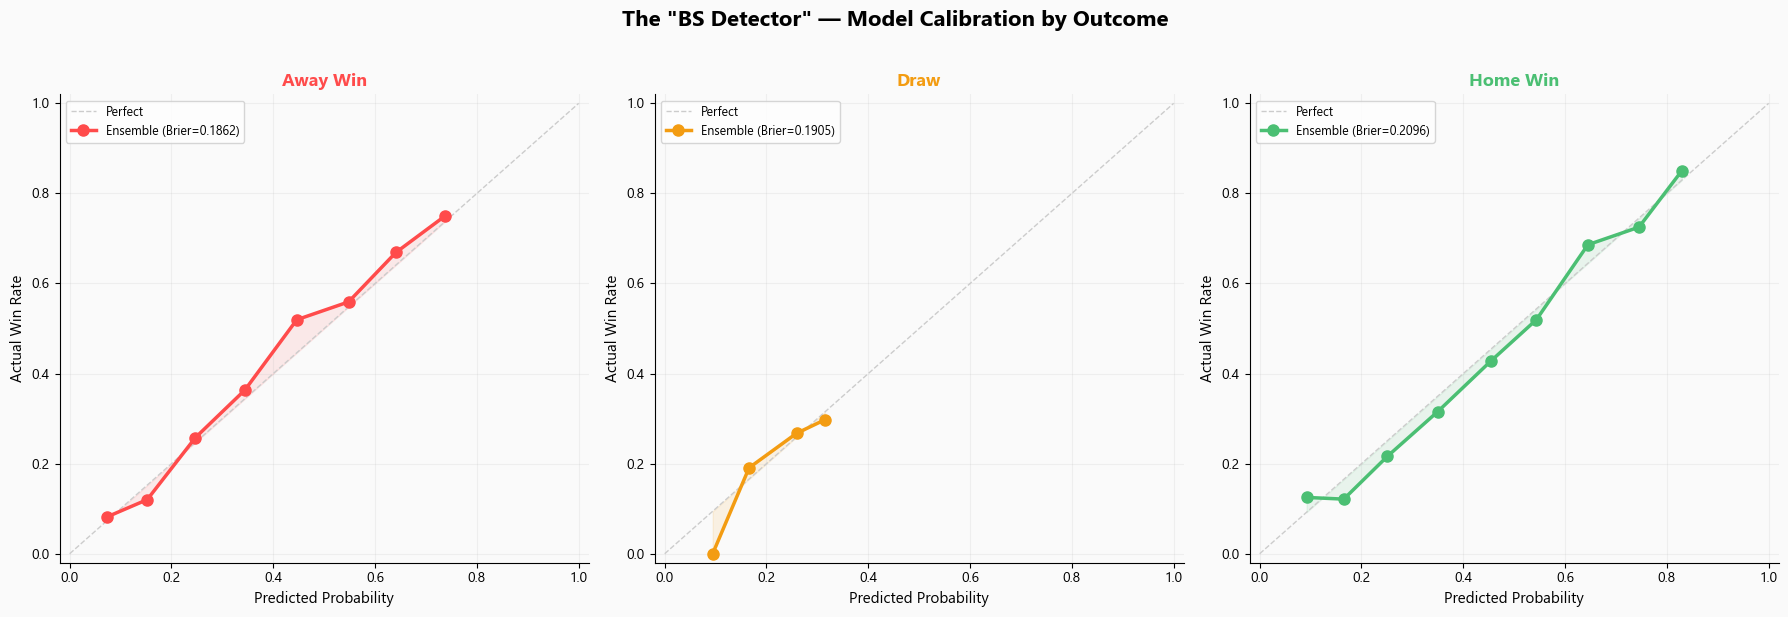

Saved: Report_Assets\Calibration_Curve.png

Interpretation: Closer the markers are to the dotted line, the more
trustworthy the probabilities are. Large gaps = the model is bluffing.


In [4]:
# =============================================================================
# Cell 4: Calibration Curve — "The BS Detector"
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.patch.set_facecolor('#fafafa')
fig.suptitle('The "BS Detector" — Model Calibration by Outcome',
             fontsize=16, fontweight='bold', y=1.02)

colors = ['#ff4b4b', '#f39c12', '#4bbf73']

for idx, (cls, name, color) in enumerate(zip([0, 1, 2], label_names, colors)):
    ax = axes[idx]
    ax.set_facecolor('#fafafa')
    
    y_binary = (y_val == cls).astype(int)
    prob_pred_cls = p_ens[:, idx]
    
    # Calibration curve
    prob_true, prob_pred = calibration_curve(
        y_binary, prob_pred_cls, n_bins=10, strategy='uniform'
    )
    
    # Brier score
    brier = brier_score_loss(y_binary, prob_pred_cls)
    
    ax.plot([0, 1], [0, 1], '--', color='#ccc', linewidth=1, label='Perfect')
    ax.plot(prob_pred, prob_true, 'o-', color=color, linewidth=2.5,
            markersize=8, label=f'Ensemble (Brier={brier:.4f})')
    
    ax.fill_between(prob_pred, prob_true, prob_pred,
                    alpha=0.1, color=color)
    
    ax.set_xlabel('Predicted Probability', fontsize=11)
    ax.set_ylabel('Actual Win Rate', fontsize=11)
    ax.set_title(name, fontsize=13, fontweight='bold', color=color)
    ax.legend(loc='upper left', fontsize=9)
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.15)

plt.tight_layout()
cal_path = os.path.join(assets, 'Calibration_Curve.png')
plt.savefig(cal_path, dpi=300, bbox_inches='tight', facecolor='#fafafa')
plt.show()
print(f'Saved: {cal_path}')
print(f'\nInterpretation: Closer the markers are to the dotted line, the more')
print(f'trustworthy the probabilities are. Large gaps = the model is bluffing.')

In [5]:
# =============================================================================
# Cell 5: Monte Carlo Simulation with Context-Aware Probabilities
# =============================================================================

# --- Prepare future data ---
# Forward-fill any remaining NaN in SOS cols (edge cases)
future_eng[features] = future_eng[features].ffill().bfill()
fut_mask = future_eng[features].notna().all(axis=1)
future_clean = future_eng[fut_mask].copy()

print(f'Future matches: {len(future_clean)}')

# --- Ensemble probabilities ---
X_fut = future_clean[features]
X_fut_sc = scaler.transform(X_fut)

probs = (
    lr.predict_proba(X_fut_sc) +
    rf.predict_proba(X_fut) +
    gb.predict_proba(X_fut)
) / 3.0

print(f'Mean probs: A={probs[:,0].mean():.3f}, D={probs[:,1].mean():.3f}, H={probs[:,2].mean():.3f}')

# --- Banked points ---
all_teams = pd.concat([
    banked_eng['home_team'], banked_eng['away_team'],
    future_clean['home_team'], future_clean['away_team']
]).unique()

team_league = {}
for src in [banked_eng, future_clean]:
    for _, row in src.iterrows():
        team_league[row['home_team']] = row['league']
        team_league[row['away_team']] = row['league']

banked_pts = {t: 0 for t in all_teams}
banked_mp  = {t: 0 for t in all_teams}
for _, row in banked_eng.iterrows():
    h, a, res = row['home_team'], row['away_team'], row['FTR']
    banked_mp[h] += 1; banked_mp[a] += 1
    if res == 'H':   banked_pts[h] += 3
    elif res == 'A': banked_pts[a] += 3
    else:            banked_pts[h] += 1; banked_pts[a] += 1

# --- Simulation ---
print(f'\nRunning {simulations:,} simulations...')
cum_probs = np.cumsum(probs, axis=1)
home_teams = future_clean['home_team'].values
away_teams = future_clean['away_team'].values
n_matches = len(probs)
pts_h = np.array([0, 1, 3])  # outcome 0=Away, 1=Draw, 2=Home
pts_a = np.array([3, 1, 0])

sim_results = {t: np.full(simulations, banked_pts[t], dtype=float) for t in all_teams}

for s in range(simulations):
    rolls = np.random.rand(n_matches)
    outcomes = np.zeros(n_matches, dtype=int)
    outcomes[rolls >= cum_probs[:, 0]] = 1
    outcomes[rolls >= cum_probs[:, 1]] = 2
    for m in range(n_matches):
        sim_results[home_teams[m]][s] += pts_h[outcomes[m]]
        sim_results[away_teams[m]][s] += pts_a[outcomes[m]]
    if (s + 1) % 2000 == 0:
        print(f'  ... {s+1:,} / {simulations:,}')

print('Simulation complete.')

Future matches: 648
Mean probs: A=0.317, D=0.258, H=0.426

Running 10,000 simulations...
  ... 2,000 / 10,000
  ... 4,000 / 10,000
  ... 6,000 / 10,000
  ... 8,000 / 10,000
  ... 10,000 / 10,000
Simulation complete.


In [6]:
# =============================================================================
# Cell 6: Aggregate, Compare, and Export
# =============================================================================

summary = []
for team in all_teams:
    arr = sim_results[team]
    summary.append({
        'team': team,
        'league': team_league.get(team, 'Unknown'),
        'pts': banked_pts[team],
        'mp': banked_mp.get(team, 0),
        'ctx_projected': np.mean(arr),
        'ctx_p5': np.percentile(arr, 5),
        'ctx_p95': np.percentile(arr, 95),
        'ctx_std': np.std(arr),
    })

df_ctx = pd.DataFrame(summary)
df_ctx['ctx_rank'] = df_ctx.groupby('league')['ctx_projected'].rank(
    ascending=False, method='first'
).astype(int)
df_ctx = df_ctx.sort_values(['league', 'ctx_rank'])

# --- Save ---
ctx_path = os.path.join(res, 'Ensemble_Context_Projection.csv')
df_ctx.to_csv(ctx_path, index=False)
print(f'Saved: {ctx_path}')

# --- Compare with vanilla Ensemble (Phase 9) ---
ens_path = os.path.join(res, 'Ensemble_Projection.csv')
if os.path.exists(ens_path):
    df_ens = pd.read_csv(ens_path)
    cmp = pd.merge(
        df_ctx[['team', 'league', 'ctx_projected', 'ctx_rank']],
        df_ens[['team', 'ens_projected', 'ens_rank']],
        on='team', how='left'
    )
    cmp['ctx_vs_ens'] = cmp['ctx_projected'] - cmp['ens_projected']
    cmp['rank_shift'] = cmp['ens_rank'] - cmp['ctx_rank']  # positive = climbed
    
    print(f'\n{"="*65}')
    print('CONTEXT vs VANILLA ENSEMBLE — Biggest Movers')
    print(f'{"="*65}')
    print('\n▲ Most boosted by SOS:')
    for _, r in cmp.nlargest(5, 'ctx_vs_ens').iterrows():
        print(f'  {r["team"]:<20s}  Context: {r["ctx_projected"]:.1f}  '
              f'Vanilla: {r["ens_projected"]:.1f}  ({r["ctx_vs_ens"]:+.1f})')
    print('\n▼ Most penalised by SOS:')
    for _, r in cmp.nsmallest(5, 'ctx_vs_ens').iterrows():
        print(f'  {r["team"]:<20s}  Context: {r["ctx_projected"]:.1f}  '
              f'Vanilla: {r["ens_projected"]:.1f}  ({r["ctx_vs_ens"]:+.1f})')

# --- Per-league champions ---
print(f'\n{"="*65}')
print('CONTEXT-AWARE PROJECTED CHAMPIONS')
print(f'{"="*65}')
for lg in sorted(df_ctx['league'].unique()):
    champ = df_ctx[df_ctx.league == lg].iloc[0]
    print(f'  {lg:<25s}  {champ["team"]:20s}  {champ["ctx_projected"]:.1f} pts')

Saved: data\results\Ensemble_Context_Projection.csv

CONTEXT vs VANILLA ENSEMBLE — Biggest Movers

▲ Most boosted by SOS:
  Oviedo                Context: 32.5  Vanilla: 16.0  (+16.5)
  Real Madrid           Context: 87.8  Vanilla: 85.3  (+2.4)
  Sociedad              Context: 52.0  Vanilla: 49.7  (+2.3)
  Ath Bilbao            Context: 49.5  Vanilla: 47.4  (+2.1)
  Ath Madrid            Context: 72.4  Vanilla: 70.5  (+1.9)

▼ Most penalised by SOS:
  Brighton              Context: 46.5  Vanilla: 47.2  (-0.7)
  Man City              Context: 73.6  Vanilla: 74.0  (-0.5)
  Stuttgart             Context: 59.4  Vanilla: 59.8  (-0.4)
  Marseille             Context: 60.7  Vanilla: 61.1  (-0.4)
  Werder Bremen         Context: 34.4  Vanilla: 34.8  (-0.4)

CONTEXT-AWARE PROJECTED CHAMPIONS
  ENG-Premier League         Arsenal               81.3 pts
  ESP-La Liga                Barcelona             90.3 pts
  FRA-Ligue 1                Paris SG              81.5 pts
  GER-Bundesliga          

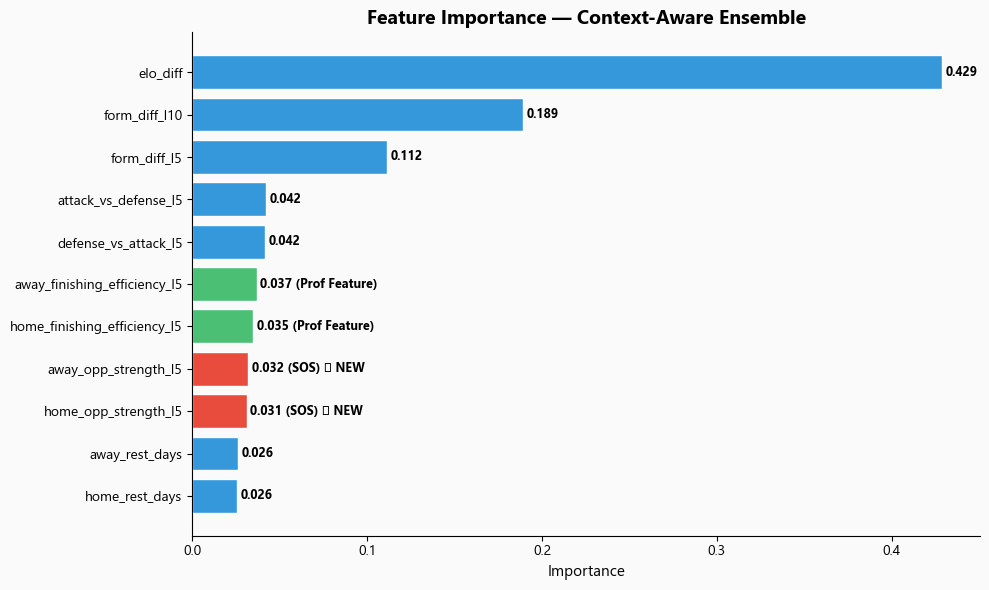

Saved: Report_Assets\Feature_Importance_Context.png

PHASE 9.5 COMPLETE — CONTEXT & CALIBRATION
  New features:     home_opp_strength_l5, away_opp_strength_l5
  Total features:   11
  Val accuracy:     52.80%
  Val log loss:     0.9832
  Simulations:      10,000

  Outputs:
    data\results\Ensemble_Context_Projection.csv
    Report_Assets\Calibration_Curve.png
    Report_Assets\Feature_Importance_Context.png


: 

In [ ]:
# =============================================================================
# Cell 7: Feature Importance — Did SOS Matter?
# =============================================================================

imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#fafafa')
ax.set_facecolor('#fafafa')

colors = ['#e74c3c' if 'opp_strength' in f
          else '#4bbf73' if 'finishing' in f
          else '#3498db'
          for f in imp.index]

ax.barh(range(len(imp)), imp.values, color=colors, edgecolor='white', linewidth=1)
ax.set_yticks(range(len(imp)))
ax.set_yticklabels(imp.index, fontsize=10)
ax.set_xlabel('Importance', fontsize=11)
ax.set_title('Feature Importance — Context-Aware Ensemble',
             fontsize=14, fontweight='bold')

# Annotations
for i, (feat, val) in enumerate(imp.items()):
    label = f'{val:.3f}'
    if 'opp_strength' in feat:
        label += ' (SOS) ◀ NEW'
    elif 'finishing' in feat:
        label += ' (Prof Feature)'
    ax.text(val + 0.002, i, label, va='center', fontsize=9, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
imp_path = os.path.join(assets, 'Feature_Importance_Context.png')
plt.savefig(imp_path, dpi=300, bbox_inches='tight', facecolor='#fafafa')
plt.show()
print(f'Saved: {imp_path}')

# --- Final summary ---
print(f'\n{"="*55}')
print('PHASE 9.5 COMPLETE — CONTEXT & CALIBRATION')
print(f'{"="*55}')
print(f'  New features:     home_opp_strength_l5, away_opp_strength_l5')
print(f'  Total features:   {len(features)}')
print(f'  Val accuracy:     {acc_ens:.2%}')
print(f'  Val log loss:     {ll_ens:.4f}')
print(f'  Simulations:      {simulations:,}')
print(f'\n  Outputs:')
print(f'    {ctx_path}')
print(f'    {cal_path}')
print(f'    {imp_path}')